# COMP5318 Assignment 2
*Make sure you change the file name with your unikey*


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
from googleapiclient.http import MediaIoBaseDownload

import numpy as np
from scipy.stats import bernoulli
import h5py
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

np.random.seed(42)

# 1. Data set up


## 1.1 Load Data

*Please upload both datasets (any file format is ok) to your google drive, and load the datasets through google drive file id in your code. If you want to use Jupyter, please submit all the dataset in an additional zip file.*



In [ ]:
# Google drive id of the data
data_id = "1JnYQFepZEkyOuSYJ-lXvANaPu80eiIJ2"
data_id_2 = "1QhdHHeUNXyRFUeMdwSvBZ4_KL4eVloZW"

# Download df1 
downloaded = drive.CreateFile({'id':data_id}) 
downloaded.GetContentFile('travelreview.csv')

# Download df2
downloaded = drive.CreateFile({'id':data_id_2}) 
downloaded.GetContentFile('paper.csv')

In [ ]:
df1 = pd.read_csv('travelreview.csv')
df2 = pd.read_csv('paper.csv')

## 1.2 Data Preprocessing (optional)

***You are required to show your data preprocessing methods for the two datasets (if necessary)***

*You can apply different data preprocessing techniques in different data and clustering models if you need.*


### Travel Review Dataset

In [ ]:
df1 = df1.drop("User ID", axis=1)

In [ ]:
df1_dist_e = pairwise_distances(df1, metric = 'euclidean')
df1_dist_c = pairwise_distances(df1, metric = 'cosine')
np.fill_diagonal(df1_dist_e, 0)
np.fill_diagonal(df1_dist_c, 0)

### ICMLA Datasets

In [ ]:
df2 = df2.drop("paper_id", axis=1)
df2['single_string'] = df2['paper_title']+df2['author_keywords']+df2['abstract']

In [ ]:
session_labels = pd.unique(df2['session'])
label_enumeration = dict()
for i, label in enumerate(session_labels):
    label_enumeration[label] = i

labels = []
for label in df2['session']:
    labels.append(label_enumeration[label])

df2['labels'] = labels

In [ ]:
###data preprocessing
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

stemmer = SnowballStemmer("english")
nltk.download('punkt')
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; 

### TfidfVectorizer will perform the vectorisation. Please explore the parameters at the user guide
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(df2['single_string'])
#dist = 1 - cosine_similarity(tfidf_matrix)

df2_dist_e = pairwise_distances(tfidf_matrix, metric = 'euclidean')
df2_dist_c = pairwise_distances(tfidf_matrix, metric = 'cosine')
np.fill_diagonal(df2_dist_e, 0)
np.fill_diagonal(df2_dist_c, 0)

#sns.set()
#ax = sns.heatmap(dist)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'tw



---


# 2. K-means Clustering

## 2.1 Travel Review Dataset

### Train K-means clustering

In [ ]:
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.metrics import silhouette_score
import random

rng = random.seed(0)

def cluster_centroid(X, distance, k):
  clusterer = KMeansClusterer(k, distance, repeats=10, avoid_empty_clusters=True, rng=rng)
  clusters = clusterer.cluster(X, True)
  centroid = np.asarray(clusterer.means())
  clusters = np.asarray(clusters)
  return centroid, clusters

In [ ]:
def inertia(feature_matrix, centroid, cluster):
     sum_ = []
     for i in range(feature_matrix.shape[0]):
         sum_.append(np.sum((feature_matrix[i] - centroid[cluster[i]])**2))  #here implementing inertia as given in the docs of scikit i.e sum of squared distance..

     return sum(sum_)

In [ ]:
feature_matrix = np.asarray(df1)

max_k = 10

clusters_e = []
clusters_c = []

inertias_e = []
inertias_c = []

silhouette_e = []
silhouette_c = []


for k in range(1, max_k):
    centroid_e, cluster_e = cluster_centroid(feature_matrix, euclidean_distance, k)
    centroid_c, cluster_c = cluster_centroid(feature_matrix, cosine_distance, k)

    clusters_e.append(cluster_e)
    clusters_c.append(cluster_c)

    inertias_e.append(inertia(feature_matrix, centroid_e, cluster_e))
    inertias_c.append(inertia(feature_matrix, centroid_c, cluster_c))

    if k is not 1:
        silhouette_e.append(silhouette_score(df1_dist_e, cluster_e, metric='precomputed'))
        silhouette_c.append(silhouette_score(df1_dist_c, cluster_c, metric='precomputed'))

### First evaluation 

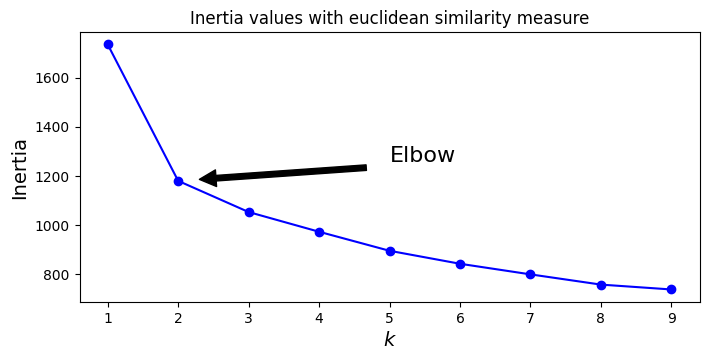

<Figure size 640x480 with 0 Axes>

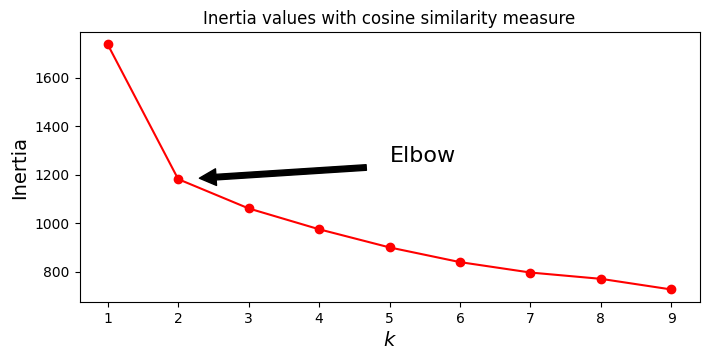

In [ ]:
plt.style.use('default')
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_k), inertias_e, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias_e[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.title("Inertia values with euclidean similarity measure")
plt.show()

plt.savefig('inertia_e1.png')

plt.style.use('default')
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_k), inertias_c, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias_e[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.title("Inertia values with cosine similarity measure")
plt.show()

### Second evaluation 

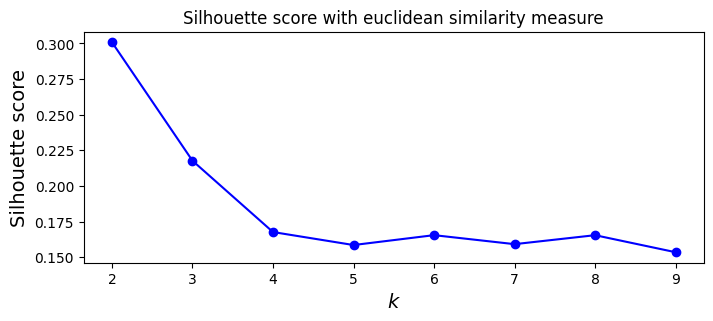

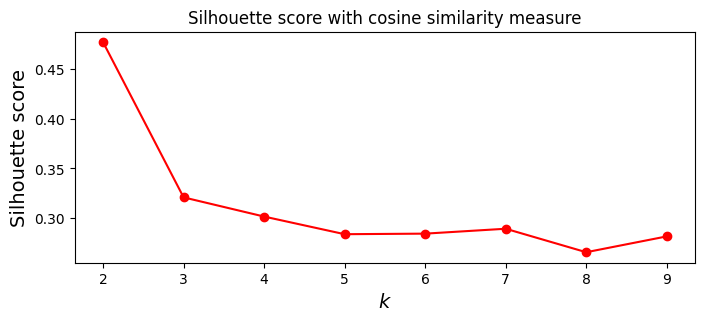

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, max_k), silhouette_e, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with euclidean similarity measure")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, max_k), silhouette_c, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with cosine similarity measure")
plt.show()

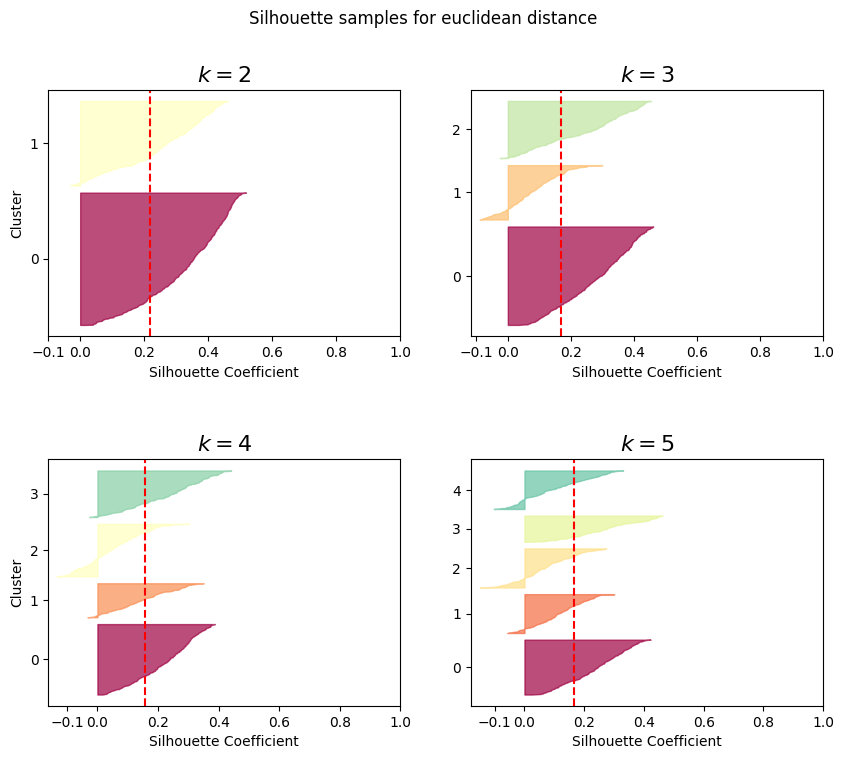

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

fig = plt.figure(figsize=(10, 8))


k_start = 2
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = clusters_e[k - 1]
    silhouette_coefficients = silhouette_samples(df1_dist_e, y_pred, metric='precomputed')

    padding = len(df1_dist_e) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_e[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
    fig.suptitle("Silhouette samples for euclidean distance")

plt.show()


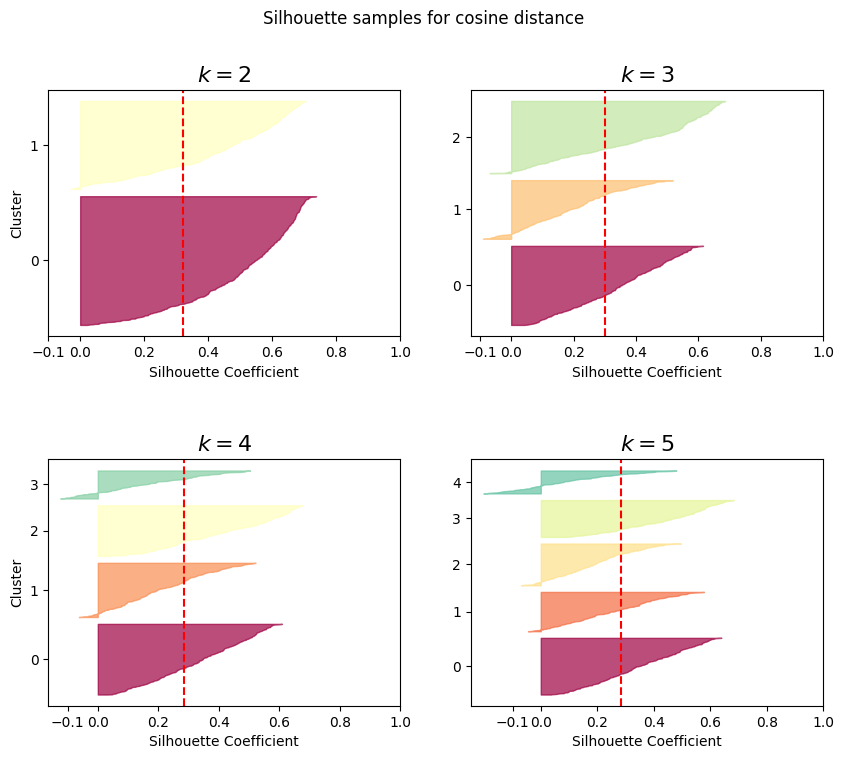

In [ ]:
fig = plt.figure(figsize=(10, 8))

k_start = 2
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = clusters_c[k - 1]
    silhouette_coefficients = silhouette_samples(df1_dist_c, y_pred, metric='precomputed')

    padding = len(df1_dist_c) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_c[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
    fig.suptitle("Silhouette samples for cosine distance")

plt.show()

## 2.2 ICMLA Dataset

### Train K-means clustering

In [ ]:
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.metrics import silhouette_score
import random

rng = random.seed(0)

def cluster_centroid(X, distance, k):
  clusterer = KMeansClusterer(k, distance, repeats=10, avoid_empty_clusters=True, rng=rng)
  clusters = clusterer.cluster(X, True)
  centroid = np.asarray(clusterer.means())
  clusters = np.asarray(clusters)
  return centroid, clusters

In [ ]:
def inertia(feature_matrix, centroid, cluster):
     sum_ = []
     for i in range(feature_matrix.shape[0]):
         sum_.append(np.sum((feature_matrix[i] - centroid[cluster[i]])**2))  #here implementing inertia as given in the docs of scikit i.e sum of squared distance..

     return sum(sum_)

In [ ]:
feature_matrix = np.asarray(tfidf_matrix.todense())

max_k = 10

clusters_e = []
clusters_c = []

inertias_e = []
inertias_c = []

silhouette_e = []
silhouette_c = []


for k in range(1, max_k):
    centroid_e, cluster_e = cluster_centroid(feature_matrix, euclidean_distance, k)
    centroid_c, cluster_c = cluster_centroid(feature_matrix, cosine_distance, k)

    clusters_e.append(cluster_e)
    clusters_c.append(cluster_c)

    inertias_e.append(inertia(feature_matrix, centroid_e, cluster_e))
    inertias_c.append(inertia(feature_matrix, centroid_c, cluster_c))

    if k is not 1:
        silhouette_e.append(silhouette_score(df2_dist_e, cluster_e, metric='precomputed'))
        silhouette_c.append(silhouette_score(df2_dist_c, cluster_c, metric='precomputed'))

### First evaluation

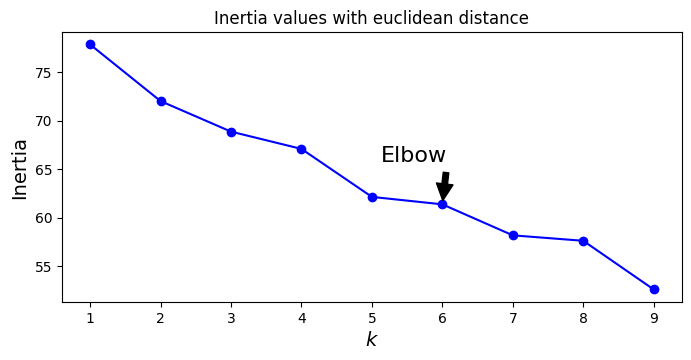

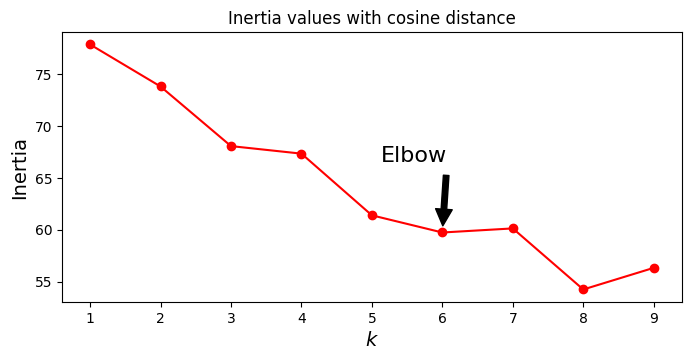

In [ ]:
plt.style.use('default')
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_k), inertias_e, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(6, inertias_e[5]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.title("Inertia values with euclidean distance")
plt.show()

plt.style.use('default')
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_k), inertias_c, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(6, inertias_c[5]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.title("Inertia values with cosine distance")
plt.show()

### Second evaluation 

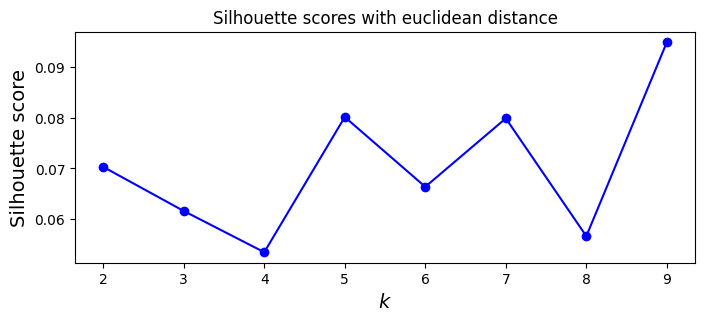

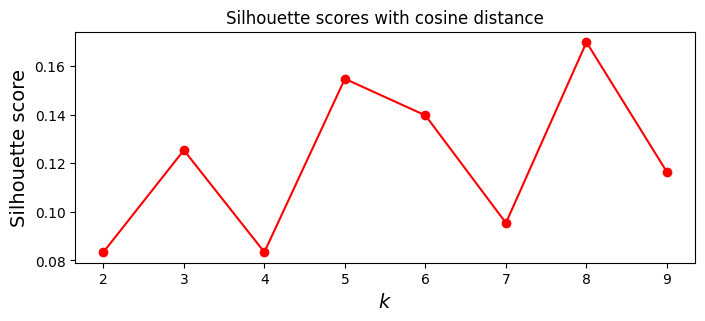

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, max_k), silhouette_e, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette scores with euclidean distance")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, max_k), silhouette_c, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette scores with cosine distance")
plt.show()

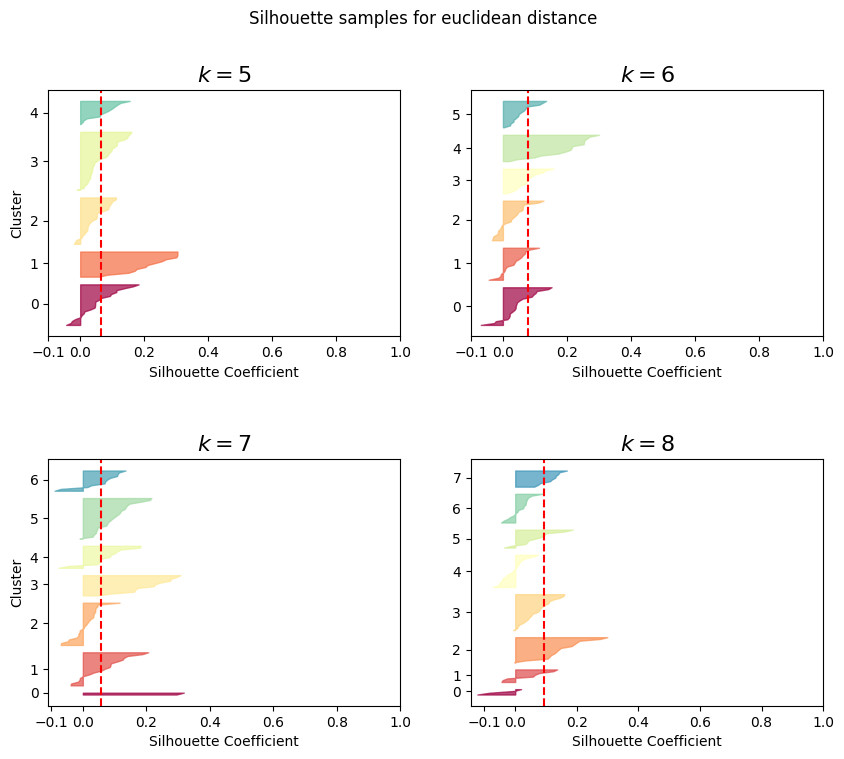

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

fig = plt.figure(figsize=(10, 8))

k_start = 5
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = clusters_e[k - 1]
    silhouette_coefficients = silhouette_samples(df2_dist_e, y_pred, metric='precomputed')

    padding = len(df2_dist_e) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_e[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

    fig.suptitle("Silhouette samples for euclidean distance")

plt.show()

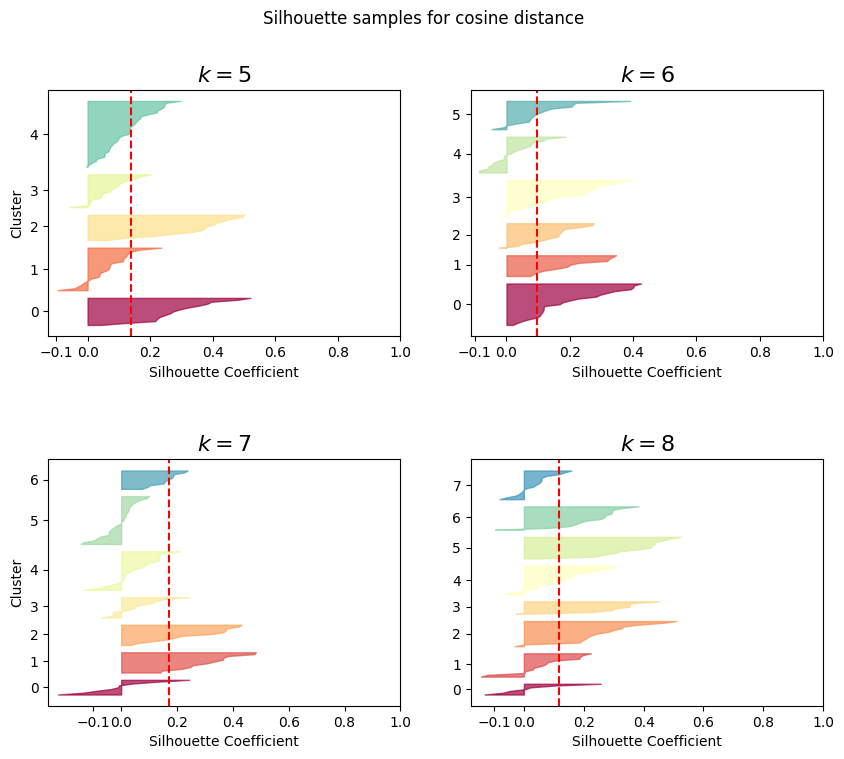

In [ ]:
fig = plt.figure(figsize=(10, 8))

k_start = 5
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = clusters_c[k - 1]
    silhouette_coefficients = silhouette_samples(df2_dist_c, y_pred, metric='precomputed')

    padding = len(df2_dist_c) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_c[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

    fig.suptitle("Silhouette samples for cosine distance")

plt.show()

### Third evaluation

In [ ]:
# Function taken from:
# https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

true = df2['labels'].values

purity_e = [purity_score(true, cluster) for cluster in clusters_e]
purity_c = [purity_score(true, cluster) for cluster in clusters_c]

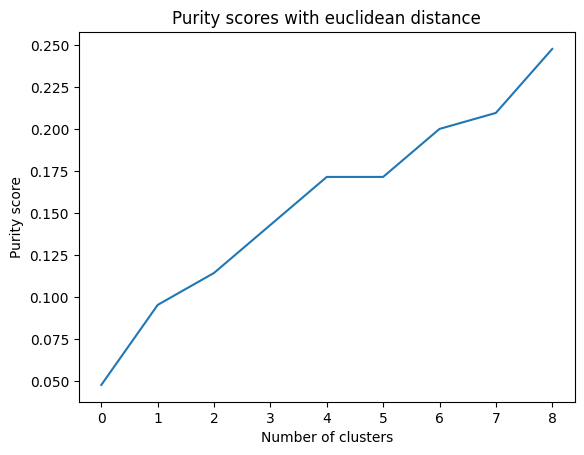

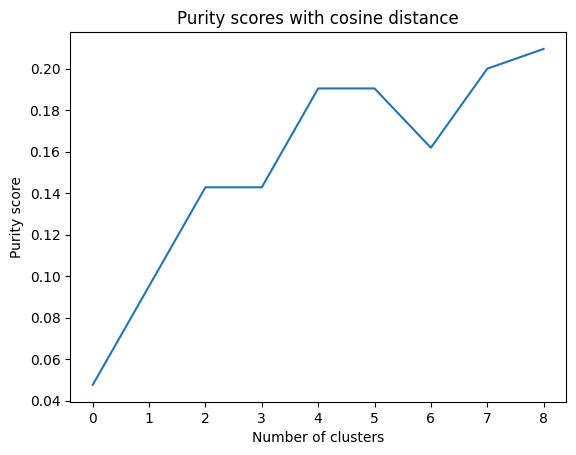

In [ ]:
plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Purity score")
plt.plot(purity_e)
plt.title("Purity scores with euclidean distance")
plt.show()

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Purity score")
plt.plot(purity_c)
plt.title("Purity scores with cosine distance")
plt.show()



---


# 3. Hierachical Clustering

## 3.1 Travel Review Dataset

### Train Hierarchical clustering 

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model_e = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
model_e.fit(df1_dist_e)
labelse = model_e.labels_

model_c = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
model_c.fit(df1_dist_c)
labelsc = model_c.labels_

### First evaluation 

In [ ]:
from sklearn.metrics import silhouette_score
similarity_measure = 'euclidean'

agglomerative_per_k_single = [AgglomerativeClustering(n_clusters=k, affinity=similarity_measure, linkage='single').fit(df1)
    for k in range(1, 25)]
silhouette_scores_single = [silhouette_score(df1, model.labels_, metric=similarity_measure)
    for model in agglomerative_per_k_single[1:]]

agglomerative_per_k_average = [AgglomerativeClustering(n_clusters=k, affinity=similarity_measure, linkage='average').fit(df1)
    for k in range(1, 25)]
silhouette_scores_average = [silhouette_score(df1, model.labels_, metric=similarity_measure)
    for model in agglomerative_per_k_average[1:]]

agglomerative_per_k_complete = [AgglomerativeClustering(n_clusters=k, affinity=similarity_measure, linkage='complete').fit(df1)
    for k in range(1, 25)]
silhouette_scores_complete = [silhouette_score(df1, model.labels_, metric=similarity_measure)
    for model in agglomerative_per_k_complete[1:]]

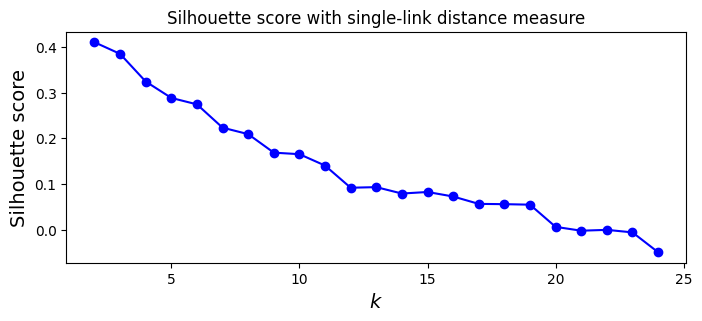

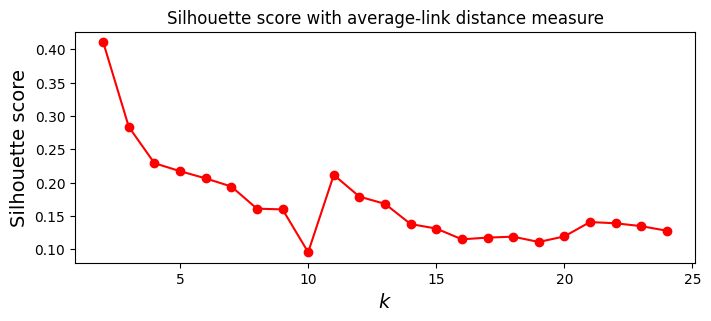

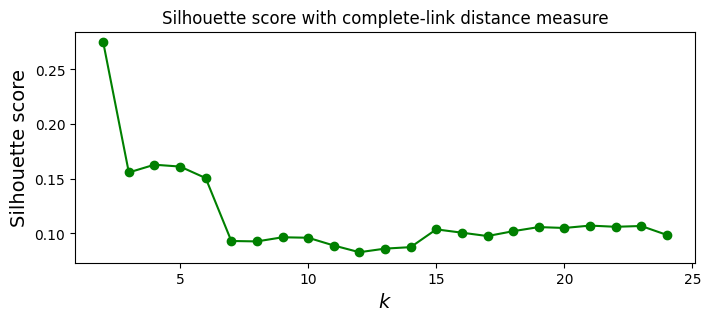

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 25), silhouette_scores_single, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with single-link distance measure")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, 25), silhouette_scores_average, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with average-link distance measure")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, 25), silhouette_scores_complete, "go-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with complete-link distance measure")
plt.show()

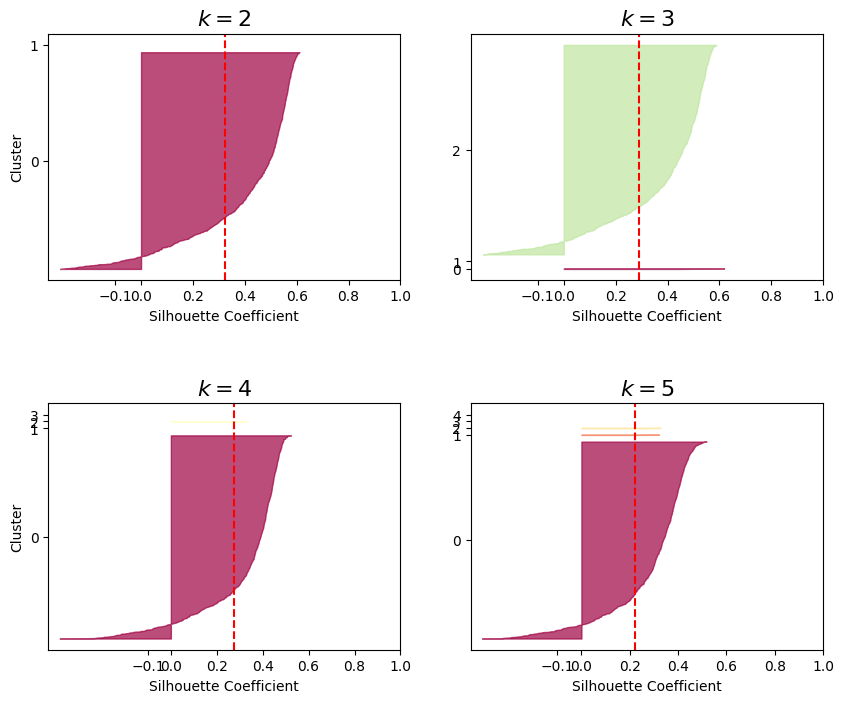

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(10, 8))

k_start = 2
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = agglomerative_per_k_single[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df1, y_pred)

    padding = len(df1) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_single[k], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

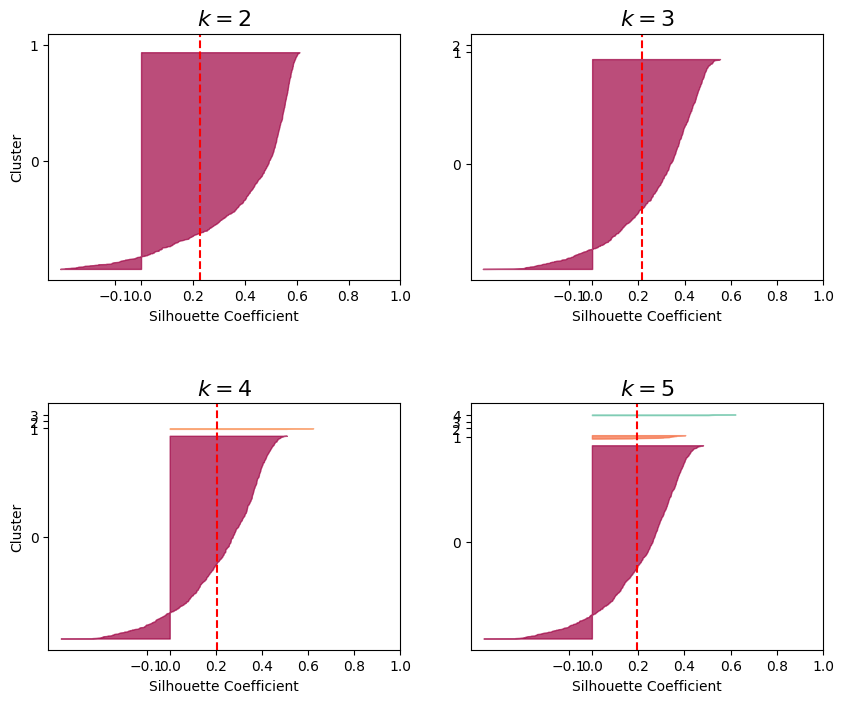

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(10, 8))

k_start = 2
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = agglomerative_per_k_average[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df1, y_pred)

    padding = len(df1) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_average[k], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

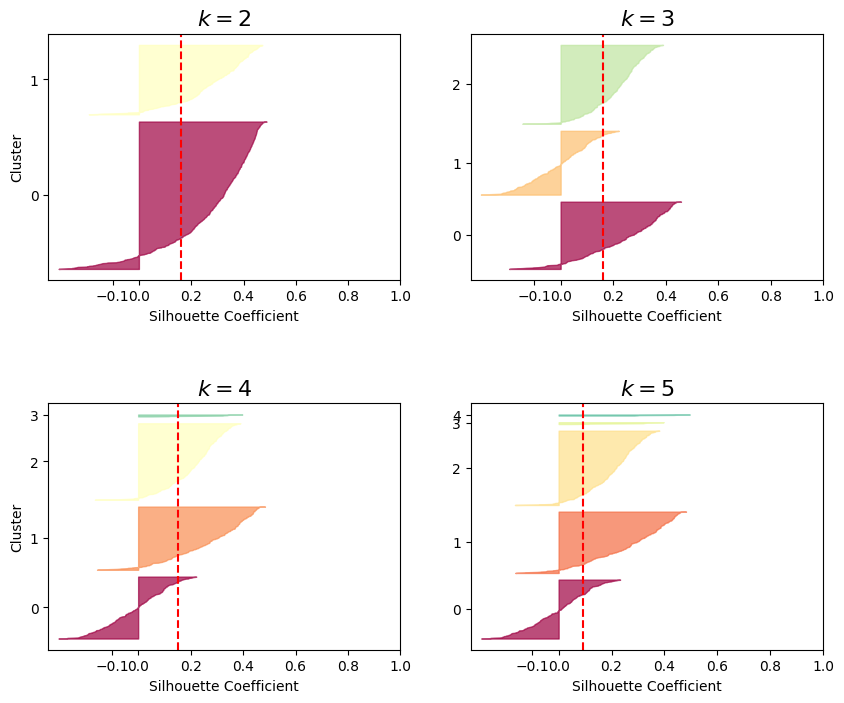

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(10, 8))

k_start = 2
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = agglomerative_per_k_complete[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df1, y_pred)

    padding = len(df1) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_complete[k], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### Second evaluation 

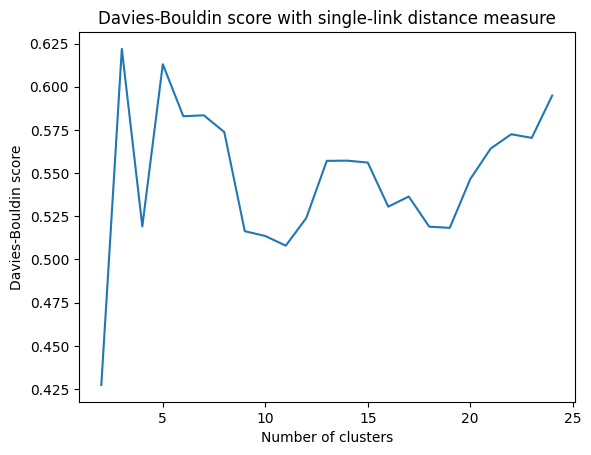

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score
db_scores_single = [davies_bouldin_score(df1, model.labels_) for model in agglomerative_per_k_single[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.plot(range(2, 25), db_scores_single)
plt.title("Davies-Bouldin score with single-link distance measure")
plt.show()

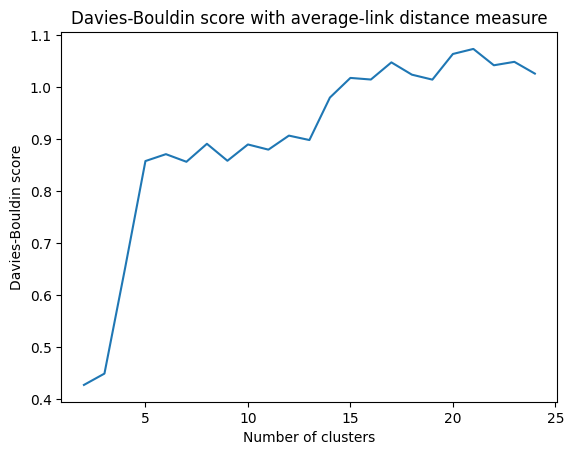

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score
db_scores_average = [davies_bouldin_score(df1, model.labels_) for model in agglomerative_per_k_average[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.plot(range(2, 25), db_scores_average)
plt.title("Davies-Bouldin score with average-link distance measure")
plt.show()

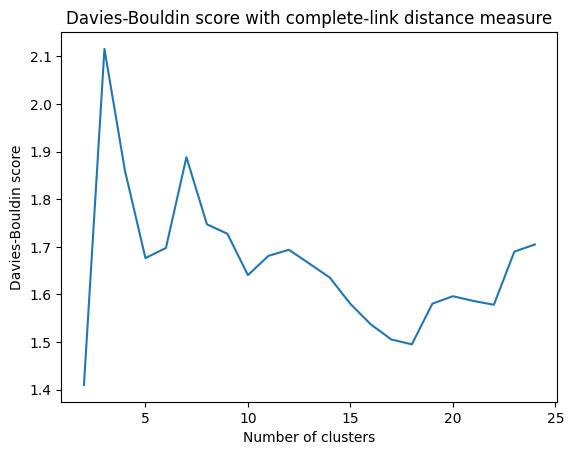

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score
db_scores_complete = [davies_bouldin_score(df1, model.labels_) for model in agglomerative_per_k_complete[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.plot(range(2, 25), db_scores_complete)
plt.title("Davies-Bouldin score with complete-link distance measure")
plt.show()

### Third **evaluation**

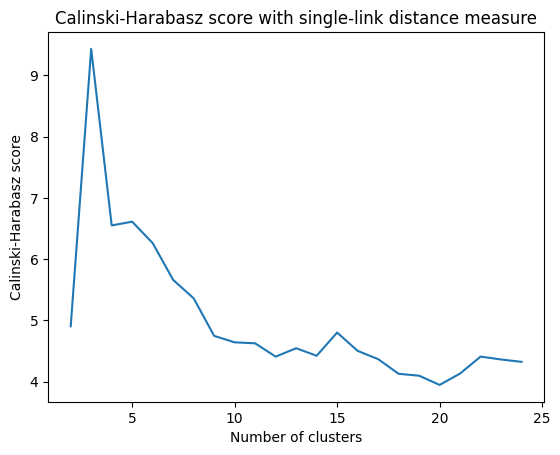

In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_scores_single = [calinski_harabasz_score(df1, model.labels_) for model in agglomerative_per_k_single[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz score")
plt.plot(range(2, 25), ch_scores_single)
plt.title("Calinski-Harabasz score with single-link distance measure")
plt.show()

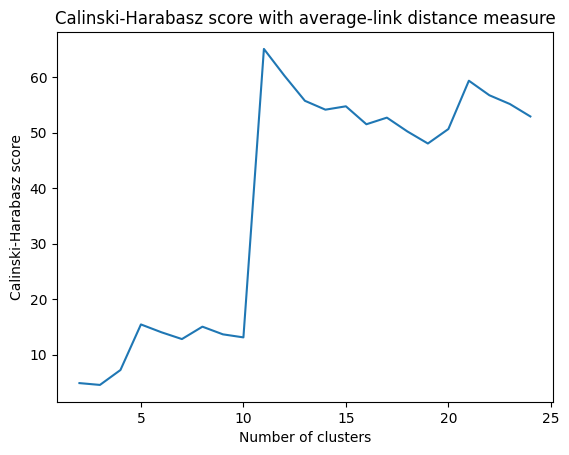

In [ ]:
ch_scores_average = [calinski_harabasz_score(df1, model.labels_) for model in agglomerative_per_k_average[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz score")
plt.plot(range(2, 25), ch_scores_average)
plt.title("Calinski-Harabasz score with average-link distance measure")
plt.show()

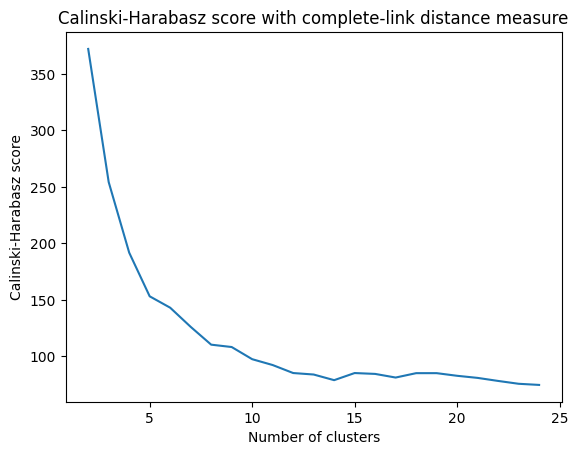

In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_scores_complete = [calinski_harabasz_score(df1, model.labels_) for model in agglomerative_per_k_complete[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz score")
plt.plot(range(2, 25), ch_scores_complete)
plt.title("Calinski-Harabasz score with complete-link distance measure")
plt.show()

## 3.2 ICMLA Dataset

### Train Hierarchical clustering 

In [ ]:
from sklearn.cluster import AgglomerativeClustering

feature_matrix = np.asarray(tfidf_matrix.todense())

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(feature_matrix)
labels = model.labels_

### First evaluation

In [ ]:
from sklearn.metrics import silhouette_score
similarity_measure = 'euclidean'

feature_matrix = tfidf_matrix.todense()

agglomerative_per_k_single = [AgglomerativeClustering(n_clusters=k, affinity=similarity_measure, linkage='single').fit(feature_matrix)
    for k in range(1, 25)]
silhouette_scores_single = [silhouette_score(feature_matrix, model.labels_, metric=similarity_measure)
    for model in agglomerative_per_k_single[1:]]

agglomerative_per_k_average = [AgglomerativeClustering(n_clusters=k, affinity=similarity_measure, linkage='average').fit(feature_matrix)
    for k in range(1, 25)]
silhouette_scores_average = [silhouette_score(feature_matrix, model.labels_, metric=similarity_measure)
    for model in agglomerative_per_k_average[1:]]

agglomerative_per_k_complete = [AgglomerativeClustering(n_clusters=k, affinity=similarity_measure, linkage='complete').fit(feature_matrix)
    for k in range(1, 25)]
silhouette_scores_complete = [silhouette_score(feature_matrix, model.labels_, metric=similarity_measure)
    for model in agglomerative_per_k_complete[1:]]

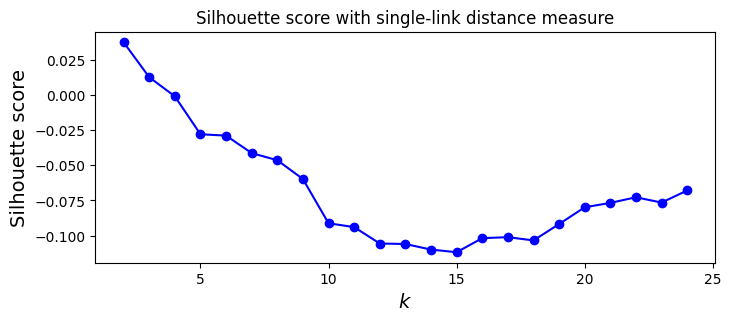

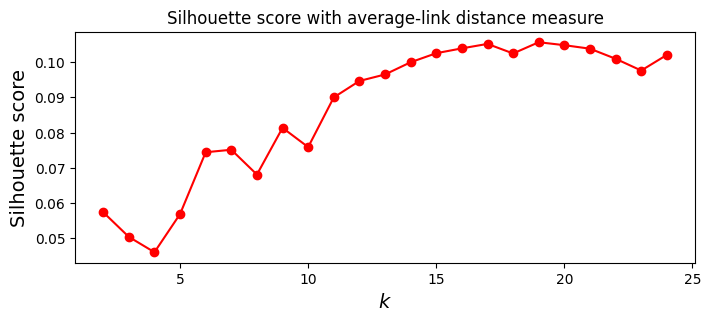

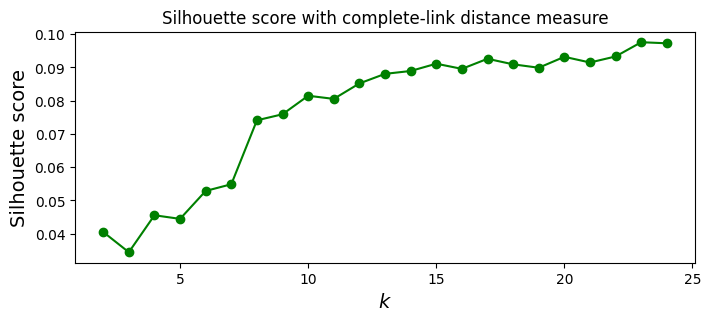

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 25), silhouette_scores_single, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with single-link distance measure")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, 25), silhouette_scores_average, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with average-link distance measure")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, 25), silhouette_scores_complete, "go-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score with complete-link distance measure")
plt.show()

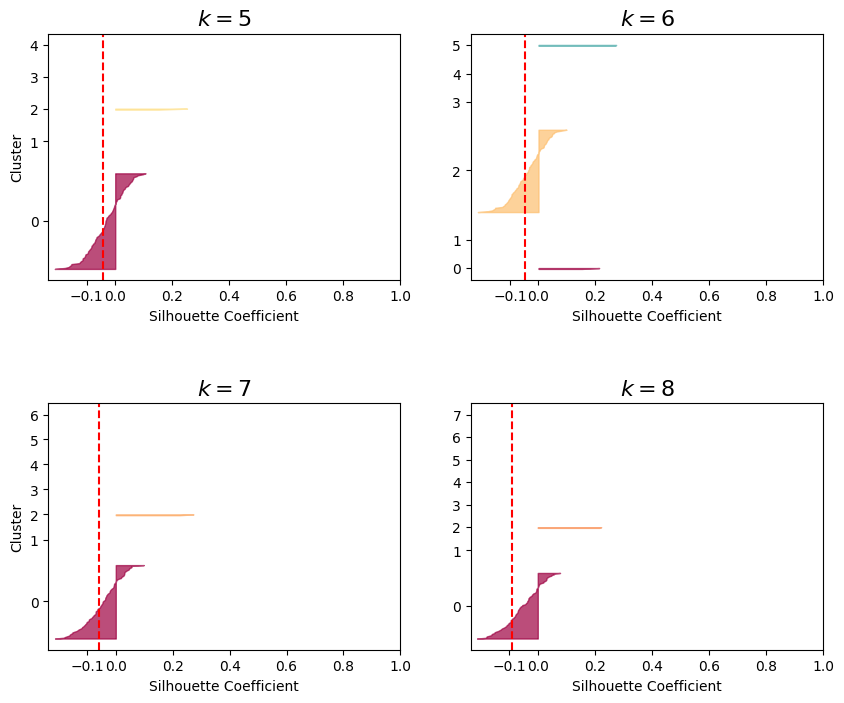

In [ ]:
plt.figure(figsize=(10, 8))

k_start = 5
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = agglomerative_per_k_single[k - 1].labels_
    silhouette_coefficients = silhouette_samples(feature_matrix, y_pred)

    padding = len(df1) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_single[k], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

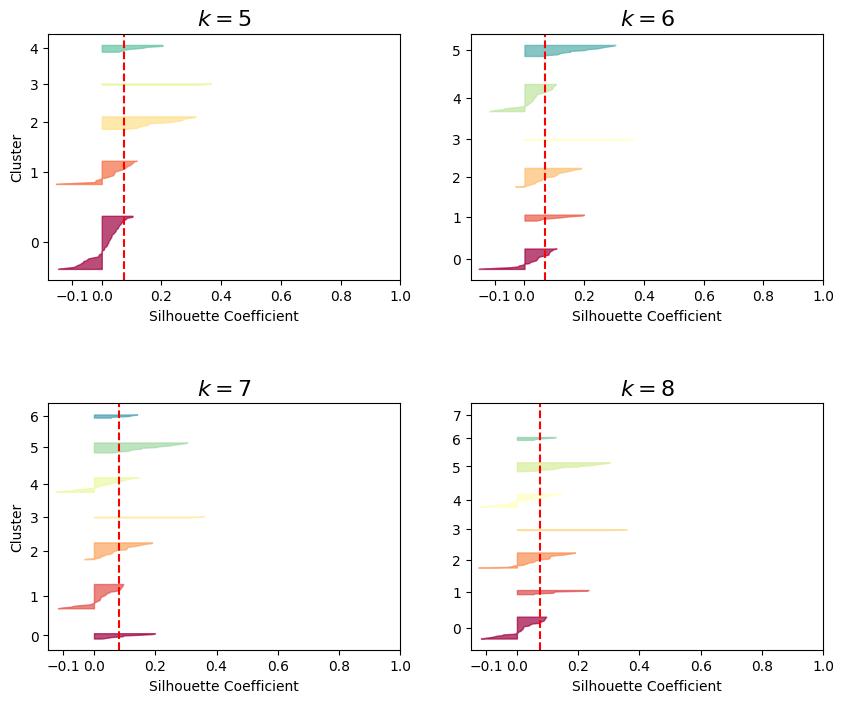

In [ ]:
plt.figure(figsize=(10, 8))

k_start = 5
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = agglomerative_per_k_average[k - 1].labels_
    silhouette_coefficients = silhouette_samples(feature_matrix, y_pred)

    padding = len(df1) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_average[k], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

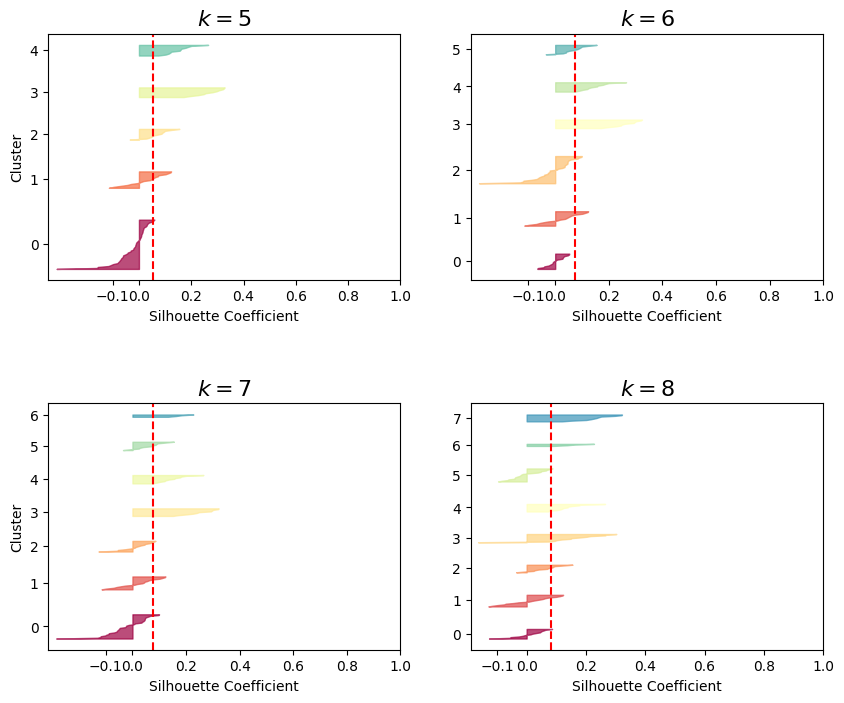

In [ ]:
plt.figure(figsize=(10, 8))

k_start = 5
k_to_plot = range(k_start, k_start + 4)

for k in k_to_plot:
    plt.subplot(2, 2, k - k_start + 1)
    plt.subplots_adjust(hspace=0.5)
    
    y_pred = agglomerative_per_k_complete[k - 1].labels_
    silhouette_coefficients = silhouette_samples(feature_matrix, y_pred)

    padding = len(df1) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (k_to_plot[0], k_to_plot[2]):
        plt.ylabel("Cluster")
    
    if k in k_to_plot:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_complete[k], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### Second evaluation 

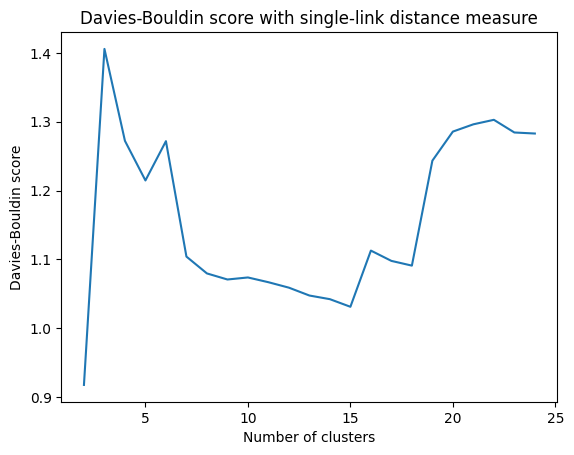

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score
db_scores_single = [davies_bouldin_score(feature_matrix, model.labels_) for model in agglomerative_per_k_single[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.plot(range(2, 25), db_scores_single)
plt.title("Davies-Bouldin score with single-link distance measure")
plt.show()

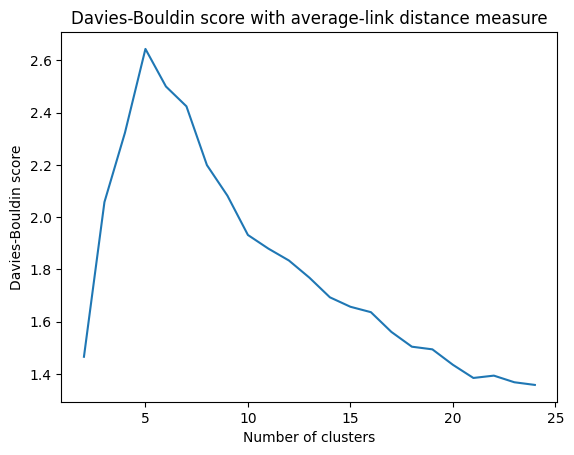

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score
db_scores_average = [davies_bouldin_score(feature_matrix, model.labels_) for model in agglomerative_per_k_average[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.plot(range(2, 25), db_scores_average)
plt.title("Davies-Bouldin score with average-link distance measure")
plt.show()

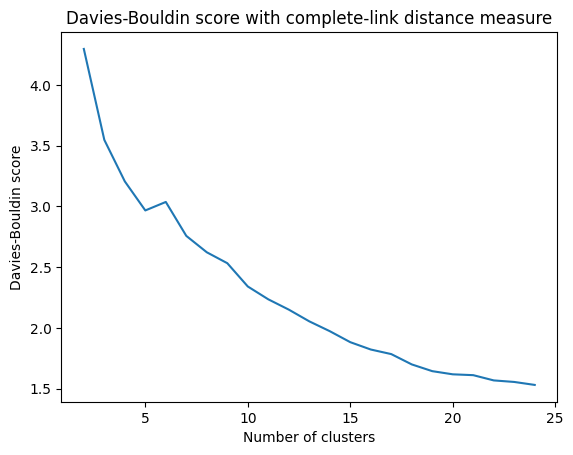

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score
db_scores_complete = [davies_bouldin_score(feature_matrix, model.labels_) for model in agglomerative_per_k_complete[1:]]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin score")
plt.plot(range(2, 25), db_scores_complete)
plt.title("Davies-Bouldin score with complete-link distance measure")
plt.show()

### Third evaluation

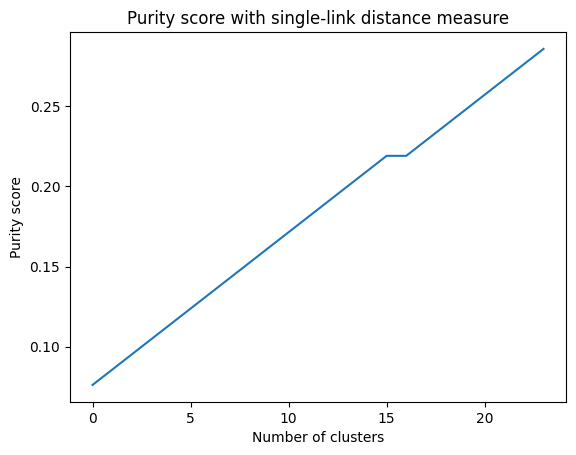

In [ ]:
# Function taken from:
# https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

true = df2['labels'].values
true = np.random.randint(min(true), max(true)+1, true.shape)
purity_single = [purity_score(true, model.labels_) for model in agglomerative_per_k_single]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Purity score")
plt.plot(purity_single)
plt.title("Purity score with single-link distance measure")
plt.show()

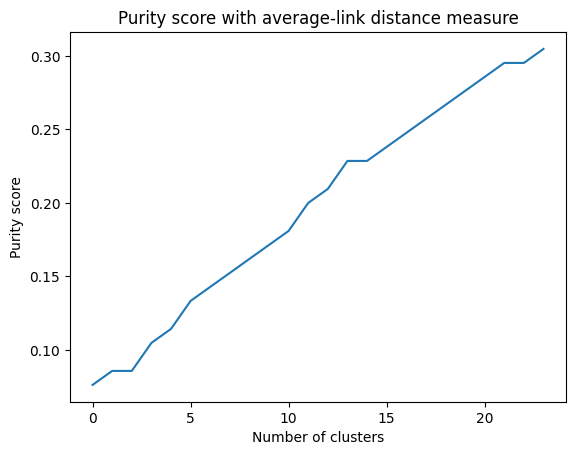

In [ ]:
purity_average = [purity_score(true, model.labels_) for model in agglomerative_per_k_average]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Purity score")
plt.plot(purity_average)
plt.title("Purity score with average-link distance measure")
plt.show()

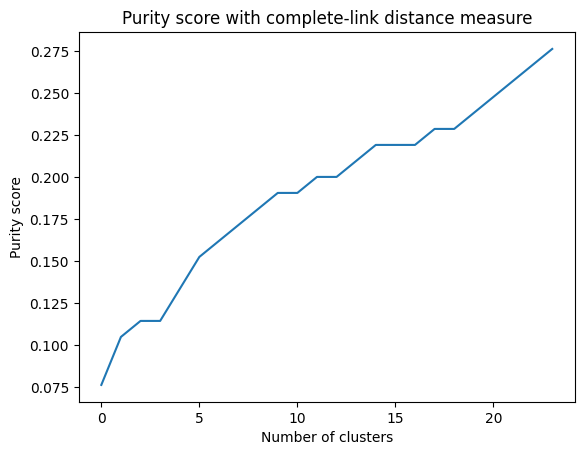

In [ ]:
purity_complete = [purity_score(true, model.labels_) for model in agglomerative_per_k_complete]

plt.figure()
plt.xlabel("Number of clusters")
plt.ylabel("Purity score")
plt.plot(purity_complete)
plt.title("Purity score with complete-link distance measure")
plt.show()



---


# 4. DBSCAN Clustering

## 4.1 Travel Review Dataset

### Train DBSCAN clustering 

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps=1.5, min_samples=4)
dbscan.fit(df1)

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=4, n_jobs=None, p=None)

### First evaluation

In [ ]:
dbscan_per_eps = [DBSCAN(eps=eps, min_samples=4, metric='euclidean').fit(df1)
    for eps in epsilon_values]

silhouette_scores_eps = []
for model in dbscan_per_eps:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1:
        silhouette_scores_eps.append(silhouette_score(df1, model.labels_, metric='euclidean'))
    else:
        silhouette_scores_eps.append(-1)

min_sample_values = range(1,11)
dbscan_per_min_samples = [DBSCAN(eps=1.5, min_samples=min_samples, metric='euclidean').fit(df1)
    for min_samples in min_sample_values]

silhouette_scores_min_samples = []
for model in dbscan_per_min_samples:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1:
        silhouette_scores_min_samples.append(silhouette_score(df1, model.labels_, metric='euclidean'))
    else:
        silhouette_scores_min_samples.append(-1)


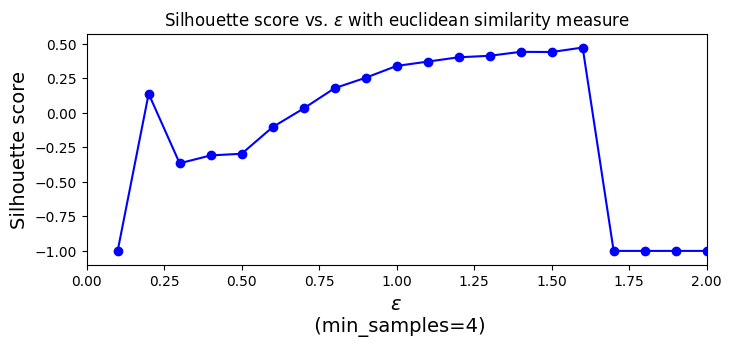

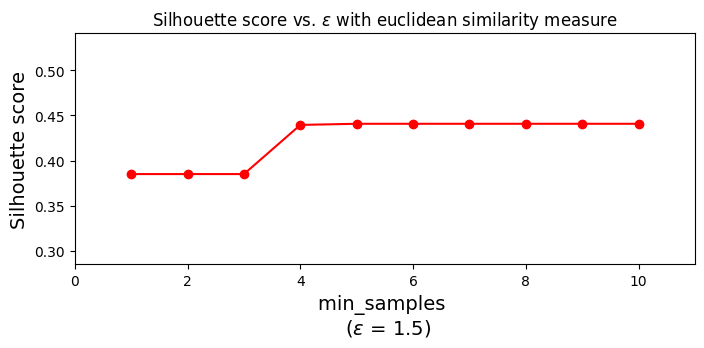

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(epsilon_values, silhouette_scores_eps, "bo-")
plt.xlabel("$\epsilon$ \n (min_samples=4)", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score vs. $\epsilon$ with euclidean similarity measure")
plt.axis([0, 2, min(silhouette_scores_eps_c) - 0.1, max(silhouette_scores_eps_c) + 0.1])
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(min_sample_values, silhouette_scores_min_samples, "ro-")
plt.xlabel("min_samples \n ($\epsilon$ = 1.5)", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score vs. $\epsilon$ with euclidean similarity measure")
plt.axis([0, 11, min(silhouette_scores_min_samples_c) - 0.1, max(silhouette_scores_min_samples_c) + 0.1])
plt.show()

### Second evaluation 

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score

db_scores_eps = []
for model in dbscan_per_eps:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1:
        db_scores_eps.append(davies_bouldin_score(X_pca, model.labels_))
    else:
        db_scores_eps.append(0)

max_db_score_eps = np.max(db_scores_eps)
for i, db_score in enumerate(db_scores_eps):
    if db_score == 0:
        db_scores_eps[i] = max_db_score_eps

db_scores_samples = []
for model in dbscan_per_min_samples:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1:
        db_scores_samples.append(davies_bouldin_score(X_pca, model.labels_))
    else:
        db_scores_samples.append(0)

max_db_score_samples = np.max(db_scores_samples)
for i, db_score in enumerate(db_scores_samples):
    if db_score == 0:
        db_scores_samples[i] = max_db_score_samples

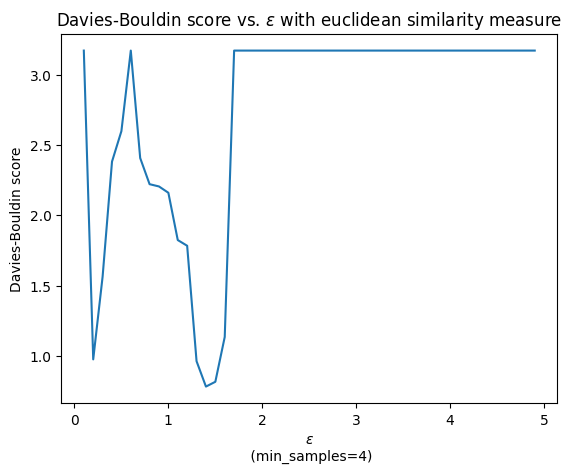

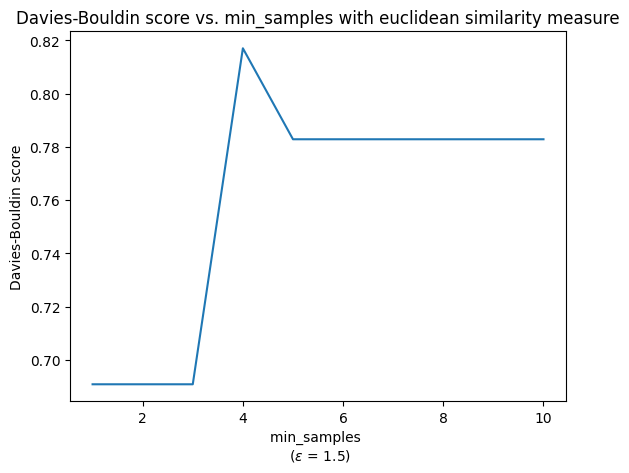

In [ ]:
plt.figure()
plt.xlabel("$\epsilon$ \n (min_samples=4)")
plt.ylabel("Davies-Bouldin score")
plt.title("Davies-Bouldin score vs. $\epsilon$ with euclidean similarity measure")
plt.plot(epsilon_values, db_scores_eps)
plt.show()

plt.figure()
plt.xlabel("min_samples \n ($\epsilon$ = 1.5)")
plt.ylabel("Davies-Bouldin score")
plt.title("Davies-Bouldin score vs. min_samples with euclidean similarity measure")
plt.plot(min_sample_values, db_scores_samples)
plt.show()

## 4.2 ICMLA Dataset

### Train DBSCAN clustering 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

feature_matrix = tfidf_matrix.todense()
scaler = StandardScaler()
feature_matrix = scaler.fit_transform(feature_matrix)

# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = feature_matrix - feature_matrix.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=7)
dbscan.fit(X_pca)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=7, n_jobs=None, p=None)

### First evaluation 

In [ ]:
epsilon_values = np.arange(0.1, 2, 0.1)
dbscan_per_eps = [DBSCAN(eps=eps, min_samples=6, metric='euclidean').fit(X_pca)
    for eps in epsilon_values]

silhouette_scores_eps = []
for model in dbscan_per_eps:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1 and num_labels < 105:
        silhouette_scores_eps.append(silhouette_score(X_pca, model.labels_, metric='euclidean'))
    else:
        silhouette_scores_eps.append(-1)

min_sample_values = range(1,11)
dbscan_per_min_samples = [DBSCAN(eps=0.8, min_samples=min_samples, metric='euclidean').fit(X_pca)
    for min_samples in min_sample_values]

silhouette_scores_min_samples = []
for model in dbscan_per_min_samples:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1 and num_labels < 105:
        silhouette_scores_min_samples.append(silhouette_score(X_pca, model.labels_, metric='euclidean'))
    else:
        silhouette_scores_min_samples.append(-1)


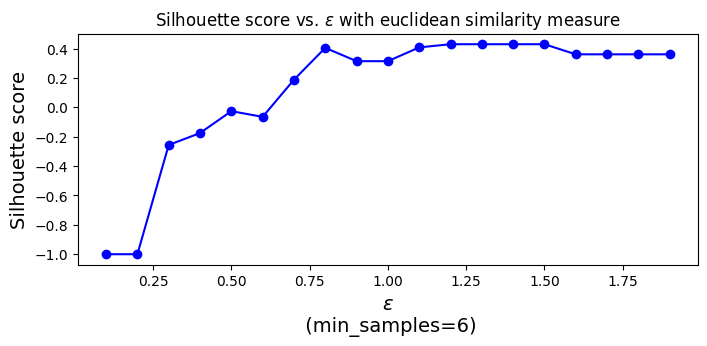

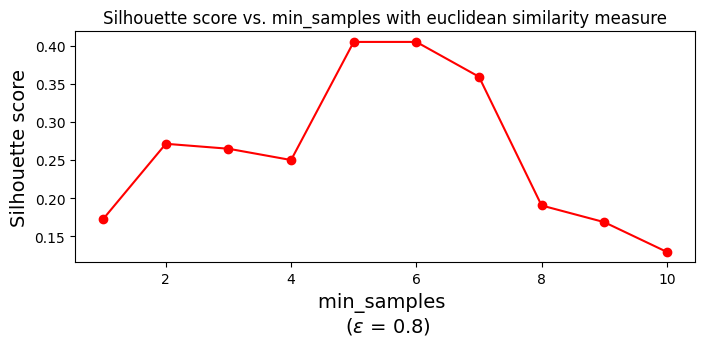

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(epsilon_values, silhouette_scores_eps, "bo-")
plt.xlabel("$\epsilon$ \n (min_samples=6)", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score vs. $\epsilon$ with euclidean similarity measure")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(min_sample_values, silhouette_scores_min_samples, "ro-")
plt.xlabel("min_samples \n ($\epsilon$ = 0.8)", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette score vs. min_samples with euclidean similarity measure")
plt.show()

### Second evaluation 

In [ ]:
# Info: https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index
# Lower score is better!
from sklearn.metrics import davies_bouldin_score

db_scores_eps = []
for model in dbscan_per_eps:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1:
        db_scores_eps.append(davies_bouldin_score(X_pca, model.labels_))
    else:
        db_scores_eps.append(0)

max_db_score_eps = np.max(db_scores_eps)
for i, db_score in enumerate(db_scores_eps):
    if db_score == 0:
        db_scores_eps[i] = max_db_score_eps

db_scores_samples = []
for model in dbscan_per_min_samples:
    num_labels = len(np.unique(model.labels_))
    if num_labels > 1:
        db_scores_samples.append(davies_bouldin_score(X_pca, model.labels_))
    else:
        db_scores_samples.append(0)

max_db_score_samples = np.max(db_scores_samples)
for i, db_score in enumerate(db_scores_samples):
    if db_score == 0:
        db_scores_samples[i] = max_db_score_samples

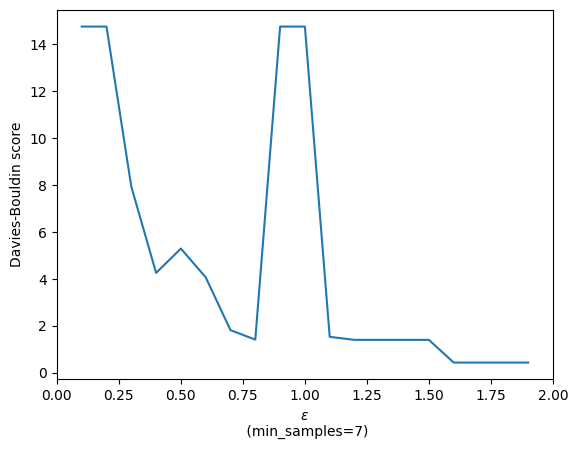

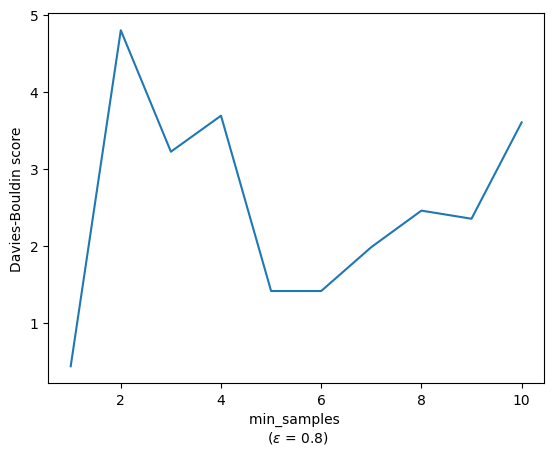

In [ ]:
plt.figure()
plt.xlabel("$\epsilon$ \n (min_samples=7)")
plt.xlim((0, 2))
plt.ylabel("Davies-Bouldin score")
plt.plot(epsilon_values, db_scores_eps)
plt.show()

plt.figure()
plt.xlabel("min_samples \n ($\epsilon$ = 0.8)")
plt.ylabel("Davies-Bouldin score")
plt.plot(min_sample_values, db_scores_samples)
plt.show()

### Third evaluation

In [ ]:
# Function taken from:
# https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

true = df2['labels'].values

purity_per_eps = [purity_score(true, model.labels_) for model in dbscan_per_eps]
purity_per_min_samples = [purity_score(true, model.labels_) for model in dbscan_per_min_samples]


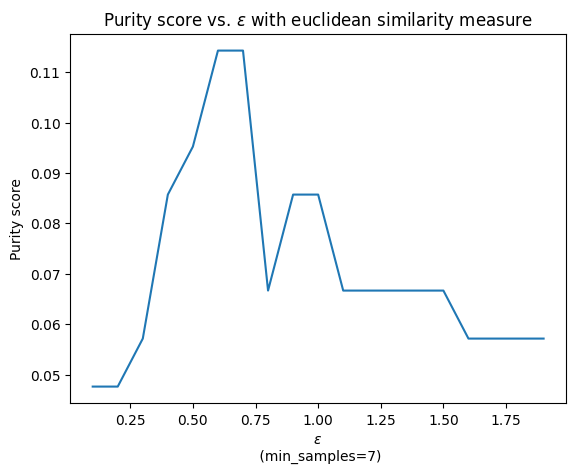

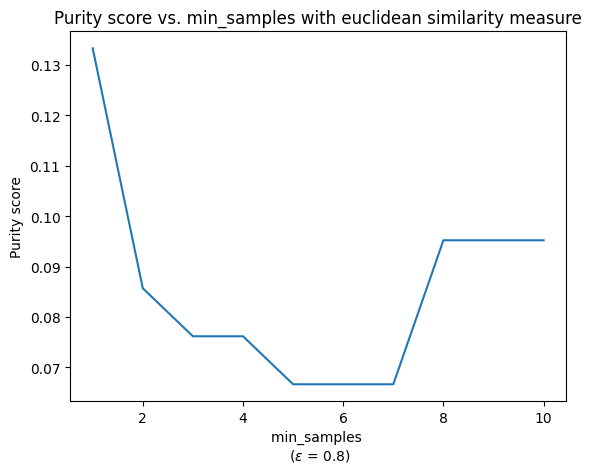

In [ ]:
plt.figure()
plt.xlabel("$\epsilon$ \n (min_samples=7)")
plt.ylabel("Purity score")
plt.title("Purity score vs. $\epsilon$ with euclidean similarity measure")
plt.plot(epsilon_values, purity_per_eps)
plt.show()

plt.figure()
plt.xlabel("min_samples \n ($\epsilon$ = 0.8)")
plt.ylabel("Purity score")
plt.title("Purity score vs. min_samples with euclidean similarity measure")
plt.plot(min_sample_values, purity_per_min_samples)
plt.show()